In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
## This function allows to execute the OS commands
def xcmd(cmd, verbose=True):
    """Runs an OS command
    :param cmd: terminal command
    :type cmd: ``str``
    :param verbose: printing the details, default True 
    :type verbose: ``boolean``
    :return: OS outputs
    :rtype: ``str``
    """

    if verbose: print('\n'+cmd)

    tmp=os.popen(cmd)
    output=''
    for x in tmp: output+=x
    if 'abort' in output:
        failure=True
    else:
        failure=tmp.close()
    if False:
        print('execution of %s failed' % cmd)
        print('error is as follows', output)
        sys.exit()
    else:
        return output


In [3]:
# !scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files ../.

In [4]:
# !scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat* ../bar_files/.

In [5]:
# This function works with both dbtable and the catalog header name on EDD
def get_catal(catal_string, infoFile="../bar_files/catalogs_info.dat", bars_folder='../bar_files/'):
    
#     xcmd("scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat ../bar_files/.", verbose=True)

    with open(infoFile, "r") as f:
        lines = f.readlines()


        try:
            for i, line in enumerate(lines):
                if catal_string in line:
                    
                    while not "begin" in line:
                        i-=1
                        line = lines[i]
                    while not "filename" in line:
                        i+=1
                        line=lines[i]

                    fname_string = line
                    break
        except: 
            return "", []
            
        catal_columns = []
        
        try:
            while not "column" in line:
                i+=1
                line=lines[i]
            while not 'end' in line:
                catal_columns.append(line.split("=>")[1].split("|")[0].strip())
                i+=1
                line=lines[i]
                
        except:
            print("why")
            return "", []


    catal_file_name = fname_string.split("=>")[1].strip("\n").strip("")
    
#     xcmd("scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files/"+catal_file_name+"  "+bars_folder+"/.", verbose=True)
    
    data = pd.read_csv(bars_folder+catal_file_name, names=catal_columns, delimiter='|')
    
    for col in catal_columns:
        if col.upper()=="PGC":
            break
    
    data.rename(columns={col:col.upper()}, inplace=True)
    data = data.set_index('PGC')
    
    # taking care of empty string
    data = data.replace(r'^\s*$', np.nan, regex=True)
    
    if "1PGC" in data.columns:
        data = data.rename(columns={"1PGC": "PGC1"})
    else:
        data["PGC1"] = data.index.values
    
    if "av_flag" in data.columns:
        data = data[data.av_flag==0]
    
    
    return data

In [6]:
def make_data(data, catalogs, catal_data, catal_key, catal_DM="DM", catal_eDM="eDM", delta=0):
    
    if not catal_key in catalogs and not catal_key in data:
        data[catal_key] = catal_data[["PGC1", catal_DM, catal_eDM]]
        data[catal_key] = data[catal_key].rename(columns={"PGC1": "PGC1_"+catal_key})
        data[catal_key] = data[catal_key].rename(columns={catal_DM: "DM_"+catal_key})
        data[catal_key] = data[catal_key].rename(columns={catal_eDM: "eDM_"+catal_key})
        
        catalogs.append(catal_key)
        
        data[catal_key]["DM_"+catal_key] += delta
        
    else:
        print("This catalog has been already imported ...")
        print("Use a different key than "+catal_key)
    
    return data, catalogs
    

In [7]:
data = {}
catalogs = []

In [8]:
catal_dbtable = "CF4 All Calibrators"
catal = get_catal(catal_dbtable)
data, catalogs = make_data(data, catalogs, catal, "Calibrators", catal_DM="DM", catal_eDM="eDM")
catal.head()

,PGC1,DM,DelTC,eDM,Vhel,So,Name
PGC,,,,,,,
35,35,29.73,NaN,0.10,335,t,UGC12894
143,143,24.91,NaN,0.07,-125,t,WLM
218,218,30.73,NaN,0.10,1050,t,NGC7814
388,388,29.65,NaN,0.11,726,t,ESO409-015
591,591,29.51,NaN,0.11,305,t,UGC00064


In [9]:
catal_dbtable = "kcf4tfrs"
catal = get_catal(catal_dbtable)

for pgc in [5896,44982,68535]:
    try: 
        catal = catal.drop(pgc)
    except:
        pass

data, catalogs = make_data(data, catalogs, catal, "TFRs", catal_DM="DM_av", catal_eDM="eDM", delta=0.172)

catal.head()

,PGC1,Nest,Vcmb,Vmod,DM_zp,DM_av,eDM,av_flag,DM_cf4,eDM_cf4,...,cf2_flag,DM_sfi,eDM_sfi,sfi_flag,DM_2mtf,eDM_2mtf,2mtf_flag,DM_flat,eDM_flat,flat_flag
PGC,,,,,,,,,,,,,,,,,,,,,
2,73150,200275,4726,4785,34.523,34.51,0.46,0,34.51,0.46,...,-10000,-10000.00,-10000.00,-10000,-10000.0,-10000.0,-10000,-10000.0,-10000.0,-10000
4,120,202766,4109,4153,33.483,33.47,0.39,0,33.49,0.49,...,0,33.54,0.39,0,-10000.0,-10000.0,-10000,-10000.0,-10000.0,-10000
12,12,210177,6195,6296,34.983,34.97,0.41,0,34.97,0.41,...,-10000,-10000.00,-10000.00,-10000,-10000.0,-10000.0,-10000,-10000.0,-10000.0,-10000
16,16,211419,5312,5386,34.643,34.63,0.45,0,34.63,0.45,...,-10000,-10000.00,-10000.00,-10000,-10000.0,-10000.0,-10000,-10000.0,-10000.0,-10000
55,55,0,4454,4506,34.233,34.22,0.39,0,33.83,0.60,...,0,34.42,0.39,0,-10000.0,-10000.0,-10000,-10000.0,-10000.0,-10000


In [10]:
len(catal)

12220

In [11]:
# catal_dbtable = "kcf4fps"
# catal = get_catal(catal_dbtable)
# data, catalogs = make_data(data, catalogs, catal, "FPs", catal_DM="DM_av", catal_eDM="eDM", delta=0.127)
# catal.head()

In [12]:
catal_dbtable = "All CF4 SNIa Samples"
catal = get_catal(catal_dbtable)
data, catalogs = make_data(data, catalogs, catal, "SNIa", catal_DM="DM_av", catal_eDM="eDM", delta=0)
catal.head()

,SNIa,IDT17g,PGC1,Vcmb,Vmod,DM_zp,DM_av,eDM,DM_pantheonplus,eDM_pantheonplus,...,DM_twins,eDM_twins,DM_avelino,eDM_avelino,RA,DE,glon,glat,sgl,sgb
PGC,,,,,,,,,,,,,,,,,,,,,
250,2006sr,0,250,6914,7042,34.912,35.05,0.13,35.07,0.25,...,NaN,NaN,NaN,NaN,0.8958,23.2008,108.8693,-38.3606,316.3211,17.6720
282,2008hj,0,282,10921,11235,35.902,36.04,0.11,35.98,0.24,...,NaN,NaN,35.97,0.12,1.0064,-11.1742,85.7160,-70.5385,282.0792,8.9703
415,2003it,0,415,7165,7301,34.992,35.13,0.14,35.14,0.25,...,NaN,NaN,NaN,NaN,1.4517,27.4491,110.6597,-34.3329,320.8087,17.8681
465,2000dg,0,616,11092,11415,35.912,36.05,0.20,NaN,NaN,...,NaN,NaN,NaN,NaN,1.5588,8.8878,104.4513,-52.3545,301.9054,14.0485
515,2002hw,0,515,4796,4857,34.142,34.28,0.15,NaN,NaN,...,NaN,NaN,NaN,NaN,1.7062,8.6285,104.5597,-52.6445,301.6830,13.8439


In [13]:
catal_dbtable = "All CF4 SBF Samples"
catal = get_catal(catal_dbtable)

for pgc in [44182]:
    try: 
        print("removed PGC "+str(pgc))
        catal = catal.drop(pgc)
    except:
        pass
    
catal = catal[catal.DM_av>27]

data, catalogs = make_data(data, catalogs, catal, "SBFs", catal_DM="DM_av", catal_eDM="eDM", delta=0.105)
catal.head()

removed PGC 44182


,PGC1,Vcmb,Vmod,DM_zp,DM_av,eDM,DM_virfor,eDM_virfor,DM_tonry,eDM_tonry,DM_cantiello,eDM_cantiello
PGC,,,,,,,,,,,,
218,218,701,702,30.423,30.47,0.14,0.0,0.0,30.47,0.14,0.0,0.0
1160,1160,804,806,31.273,31.32,0.33,0.0,0.0,31.32,0.33,0.0,0.0
2980,2980,1339,1344,31.433,31.48,0.47,0.0,0.0,31.48,0.47,0.0,0.0
4126,4126,-334,-334,27.343,27.39,0.10,0.0,0.0,27.39,0.10,0.0,0.0
4524,4524,1738,1746,32.353,32.40,0.35,0.0,0.0,32.40,0.35,0.0,0.0


In [14]:
catal_dbtable = "kcf4sniigroup"
catal = get_catal(catal_dbtable)
data, catalogs = make_data(data, catalogs, catal, "SNII", catal_DM="DM", catal_eDM="eDM", delta=-0.084)
catal.head()

,Nest,N,DMzp,DM,eDM,Vcmb,SGL,SGB,SNII,PGC1
PGC,,,,,,,,,,
2667,0,1,34.428,34.66,0.33,6549,270.2095,-4.9044,SN2008gr,2667
5271,201212,1,34.408,34.64,0.33,6146,312.8683,-3.5009,SN2007il,5271
5974,212146,1,29.568,29.80,0.97,359,314.5299,-5.3880,SN2013ej,5974
6161,201134,1,34.518,34.75,0.35,5449,270.4382,-17.2497,SN2008hg,6161
6415,200166,1,34.048,34.28,0.35,4893,311.3392,-9.4130,SN2001fa,6415


In [15]:
catalogs

['Calibrators', 'TFRs', 'SNIa', 'SBFs', 'SNII']

In [16]:
df = data["Calibrators"]

In [17]:
for cat in catalogs[1:]:
    df = df.join(data[cat], how='outer')

In [18]:
df

,PGC1_Calibrators,DM_Calibrators,eDM_Calibrators,PGC1_TFRs,DM_TFRs,eDM_TFRs,PGC1_SNIa,DM_SNIa,eDM_SNIa,PGC1_SBFs,DM_SBFs,eDM_SBFs,PGC1_SNII,DM_SNII,eDM_SNII
PGC,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,73150.0,34.682,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,120.0,33.642,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,12.0,35.142,0.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,16.0,34.802,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,35.0,29.73,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003283,NaN,NaN,NaN,NaN,NaN,NaN,9003283.0,35.05,0.10,NaN,NaN,NaN,NaN,NaN,NaN
9003285,NaN,NaN,NaN,NaN,NaN,NaN,71884.0,36.98,0.10,NaN,NaN,NaN,NaN,NaN,NaN
9003286,NaN,NaN,NaN,NaN,NaN,NaN,9003286.0,37.95,0.10,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
ss = []
for cat in catalogs[1:]:
    ss += ['PGC1_'+cat]   
df['pgc1'] = df[ss].median(axis=1)
df = df[~df['pgc1'].isna()]

In [20]:
df

,PGC1_Calibrators,DM_Calibrators,eDM_Calibrators,PGC1_TFRs,DM_TFRs,eDM_TFRs,PGC1_SNIa,DM_SNIa,eDM_SNIa,PGC1_SBFs,DM_SBFs,eDM_SBFs,PGC1_SNII,DM_SNII,eDM_SNII,pgc1
PGC,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,73150.0,34.682,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73150.0
4,NaN,NaN,NaN,120.0,33.642,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0
12,NaN,NaN,NaN,12.0,35.142,0.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
16,NaN,NaN,NaN,16.0,34.802,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
55,NaN,NaN,NaN,55.0,34.392,0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003283,NaN,NaN,NaN,NaN,NaN,NaN,9003283.0,35.05,0.10,NaN,NaN,NaN,NaN,NaN,NaN,9003283.0
9003285,NaN,NaN,NaN,NaN,NaN,NaN,71884.0,36.98,0.10,NaN,NaN,NaN,NaN,NaN,NaN,71884.0
9003286,NaN,NaN,NaN,NaN,NaN,NaN,9003286.0,37.95,0.10,NaN,NaN,NaN,NaN,NaN,NaN,9003286.0


In [21]:
df = df[df.DM_Calibrators>0]

In [22]:
len(df)

122

In [23]:
ref = "Calibrators"
for col in catalogs:
    if col!=ref:
        df0 = df[["DM_"+ref, "DM_"+col]].dropna()

        delta = df0["DM_"+ref] - df0["DM_"+col]

        print(col, np.mean(delta), np.std(delta), len(delta))

TFRs -0.10287654320987644 0.5127421892722067 81
SNIa -0.052409090909090524 0.13815493907234233 44
SBFs -0.20768965517241428 0.3279331411513612 29
SNII -0.15212500000000073 0.33742793212032623 8


In [24]:
# df[df.DM_FPs>0]

In [25]:
len(df)

122

In [26]:

df['pgc1'] = df.index.values



d = np.zeros(len(catalogs))
myDict = {}
for i, cat in enumerate(catalogs):
    myDict[cat] = d[i]

for cat in catalogs:
    df['w_'+cat] = 1./df['eDM_'+cat]**2
    df['xw_'+cat] = (df['DM_'+cat]+myDict[cat])*df['w_'+cat]

  
dg = df.groupby("pgc1").agg(["sum", "count"])

for cat in catalogs:
    dg['eDMg_'+cat] = np.sqrt(1./dg['w_'+cat]['sum'])
    dg['DMg_'+cat] = (dg['xw_'+cat]['sum'])/dg['w_'+cat]['sum']

ss = []
for cat in catalogs:
    dg['N_'+cat] = dg["DM_"+cat]['count']
    ss += ['N_'+cat, "DMg_"+cat, "eDMg_"+cat]

dg = dg[ss]
dg.replace([np.inf, -np.inf], np.nan, inplace=True)

dg.index = dg.index.astype('int')


ss = ['DMg_'+cat for cat in catalogs]+['eDMg_'+cat for cat in catalogs]
dg_ = dg[ss]

for cat in catalogs:
        dg_['gw_'+cat] = 1./dg_['eDMg_'+cat]**2

In [27]:
catalogs

['Calibrators', 'TFRs', 'SNIa', 'SBFs', 'SNII']

In [28]:
def GfastChi2(dg, theta=None):
    
    d = theta[1]
    
    myDict = {}
    for cat in catalogs[1:]:
        myDict[cat] = d
    
    myDict[catalogs[0]] = 0   # zp

    ###########################################################
        
    for cat in catalogs:
#         dg['gw_'+cat] = 1./dg['eDMg_'+cat]**2
        dg['gxw_'+cat] = (dg['DMg_'+cat]+myDict[cat])*dg['gw_'+cat]


    sx = ['gxw_'+cat for cat in catalogs]
    sw = ['gw_'+cat for cat in catalogs]
    
    ERRave2 = 1./dg[sw].sum(axis=1)
    ave = dg[sx].sum(axis=1)*ERRave2
    
    myDict[catalogs[0]] = theta[0]
    for cat in catalogs:
        dg['gxi2_'+cat] = ((dg['DMg_'+cat]+myDict[cat]-ave)**2)/(dg_['eDMg_'+cat]**2+ERRave2)


    sxi = ['gxi2_'+cat for cat in catalogs]    
    XI2 = dg[sxi].sum(axis=1)

    return XI2.sum()

In [29]:
t1 =  datetime.now()

print(GfastChi2(dg_, theta=[0,1]))
###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

3101.3028696048045
Execution time:
0:00:00.032453


In [30]:
dg.head()

,N_Calibrators,DMg_Calibrators,eDMg_Calibrators,N_TFRs,DMg_TFRs,eDMg_TFRs,N_SNIa,DMg_SNIa,eDMg_SNIa,N_SBFs,DMg_SBFs,eDMg_SBFs,N_SNII,DMg_SNII,eDMg_SNII
,,,,,,,,,,,,,,,
pgc1,,,,,,,,,,,,,,,
218,1,30.730,0.10,1,31.282,0.40,0,NaN,NaN,1,30.575,0.14,0,NaN,NaN
1014,1,26.570,0.03,1,26.212,0.41,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
1583,1,34.527,0.25,0,NaN,NaN,1,34.24,0.09,0,NaN,NaN,0,NaN,NaN
2758,1,27.800,0.02,1,27.742,0.68,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
2789,1,27.790,0.02,1,27.802,0.40,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN


In [31]:
df

,PGC1_Calibrators,DM_Calibrators,eDM_Calibrators,PGC1_TFRs,DM_TFRs,eDM_TFRs,PGC1_SNIa,DM_SNIa,eDM_SNIa,PGC1_SBFs,...,w_Calibrators,xw_Calibrators,w_TFRs,xw_TFRs,w_SNIa,xw_SNIa,w_SBFs,xw_SBFs,w_SNII,xw_SNII
PGC,,,,,,,,,,,,,,,,,,,,,
218,218.0,30.730,0.100,218.0,31.282,0.40,NaN,NaN,NaN,218.0,...,100.000000,3073.000000,6.250000,195.512500,NaN,NaN,51.020408,1559.948980,NaN,NaN
1014,1014.0,26.570,0.030,1014.0,26.212,0.41,NaN,NaN,NaN,NaN,...,1111.111111,29522.222222,5.948840,155.930993,NaN,NaN,NaN,NaN,NaN,NaN
1583,1583.0,34.527,0.250,NaN,NaN,NaN,1583.0,34.24,0.09,NaN,...,16.000000,552.432000,NaN,NaN,123.456790,4227.160494,NaN,NaN,NaN,NaN
2758,2789.0,27.800,0.020,2789.0,27.742,0.68,NaN,NaN,NaN,NaN,...,2500.000000,69500.000000,2.162630,59.995675,NaN,NaN,NaN,NaN,NaN,NaN
2789,2789.0,27.790,0.020,2789.0,27.802,0.40,NaN,NaN,NaN,NaN,...,2500.000000,69475.000000,6.250000,173.762500,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69327,69327.0,30.809,0.090,NaN,NaN,NaN,NaN,NaN,NaN,69327.0,...,123.456790,3803.580247,NaN,NaN,NaN,NaN,34.602076,1056.574394,NaN,NaN
69453,69453.0,33.246,0.117,69453.0,33.592,0.40,69453.0,33.35,0.09,NaN,...,73.051355,2428.665352,6.250000,209.950000,123.456790,4117.283951,NaN,NaN,NaN,NaN
70795,70795.0,32.500,0.119,70795.0,32.682,0.39,70795.0,32.67,0.15,NaN,...,70.616482,2295.035661,6.574622,214.871795,44.444444,1452.000000,NaN,NaN,NaN,NaN


In [32]:
len(dg_)

122

In [33]:
dg_.head()

,DMg_Calibrators,DMg_TFRs,DMg_SNIa,DMg_SBFs,DMg_SNII,eDMg_Calibrators,eDMg_TFRs,eDMg_SNIa,eDMg_SBFs,eDMg_SNII,...,gxw_Calibrators,gxw_TFRs,gxw_SNIa,gxw_SBFs,gxw_SNII,gxi2_Calibrators,gxi2_TFRs,gxi2_SNIa,gxi2_SBFs,gxi2_SNII
,,,,,,,,,,,...,,,,,,,,,,
pgc1,,,,,,,,,,,,,,,,,,,,,
218,30.730,31.282,NaN,30.575,NaN,0.10,0.40,NaN,0.14,NaN,...,3073.000000,201.762500,NaN,1610.969388,NaN,6.893383,8.891218,NaN,9.988229,NaN
1014,26.570,26.212,NaN,NaN,NaN,0.03,0.41,NaN,NaN,NaN,...,29522.222222,161.879833,NaN,NaN,NaN,0.006511,2.413002,NaN,NaN,NaN
1583,34.527,NaN,34.24,NaN,NaN,0.25,NaN,0.09,NaN,NaN,...,552.432000,NaN,4350.617284,NaN,NaN,5.718467,NaN,0.438209,NaN,NaN
2758,27.800,27.742,NaN,NaN,NaN,0.02,0.68,NaN,NaN,NaN,...,69500.000000,62.158304,NaN,NaN,NaN,0.000829,1.914070,NaN,NaN,NaN
2789,27.790,27.802,NaN,NaN,NaN,0.02,0.40,NaN,NaN,NaN,...,69475.000000,180.012500,NaN,NaN,NaN,0.007971,6.353172,NaN,NaN,NaN


In [34]:
def lnlike(theta):
    
    xi2 = GfastChi2(dg_, theta=theta)
    
    return -0.5*xi2


def lnprior(theta):
    
    return 0.0


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

In [35]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = 2, 128 # 128

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 5000) # 5000 for hours
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

Execution time:
3:05:56.740993


In [36]:
samples[:,1]

array([-0.16226151, -0.16226151, -0.16226151, ..., -0.1015386 ,
       -0.11426281, -0.11225842])

Execution time:
3:05:57.045313


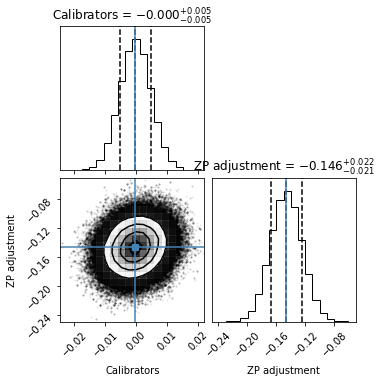

In [37]:
truths=[t[0] for t in theta]
fig = corner.corner(samples, labels=["Calibrators", "ZP adjustment"], 
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 12}, 
                    title_fmt=".3f")

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

In [38]:
npzName = "ALL_galaxy_ZP_control_.npz"
np.savez(npzName, samples)
npzfile = np.load(npzName)
print("npz attributes: ", npzfile.files)
NPZsamples = npzfile['arr_0']

npz attributes:  ['arr_0']


In [39]:
mean = np.mean(NPZsamples[:,0])

mean

-0.0002345457141562203